In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris
from sklearn.feature_selection import chi2, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#load the data
data = pd.read_csv(r'Coursework_1_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
data.shape

(12330, 18)

##Data Exploration

####Converting features' type as per the feature description

In [6]:
data1 = data.copy()
data1['OperatingSystems'] = data['OperatingSystems'].apply(str)
data1['Browser'] = data['Browser'].apply(str)
data1['Region'] = data['Region'].apply(str)
data1['TrafficType'] = data['TrafficType'].apply(str)
data1['Weekend'] = data['Weekend'].apply(str)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

####Statistics summary

In [7]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


####Identify missing values

In [8]:
print(data1.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


####Identify distinct values by features

In [9]:
data1.apply(lambda x: len(x.unique()))

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

####Scatter plot

In [10]:
#sns.pairplot(data1, hue = 'Revenue')

####Box plot

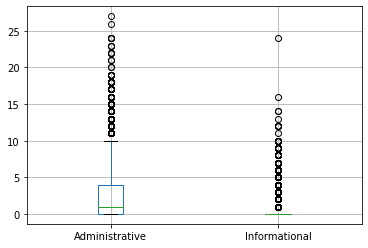

In [11]:
data1[['Administrative', 'Informational']].boxplot()

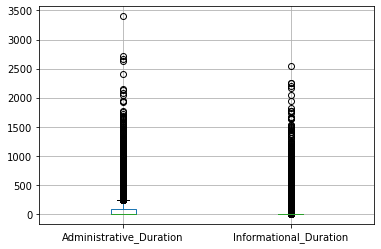

In [12]:
data1[['Administrative_Duration', 'Informational_Duration']].boxplot()

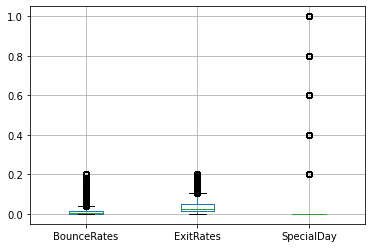

In [13]:
data1[['BounceRates', 'ExitRates', 'SpecialDay']].boxplot()

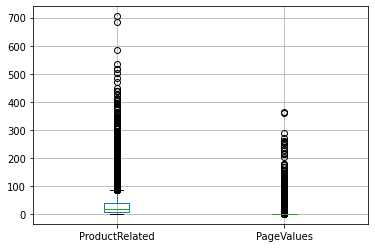

In [14]:
data1[['ProductRelated', 'PageValues']].boxplot()

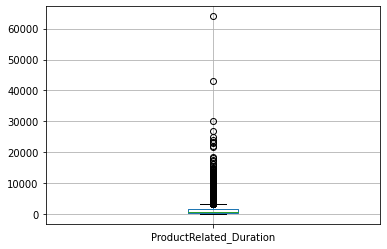

In [15]:
data1[['ProductRelated_Duration']].boxplot()

####Histogram

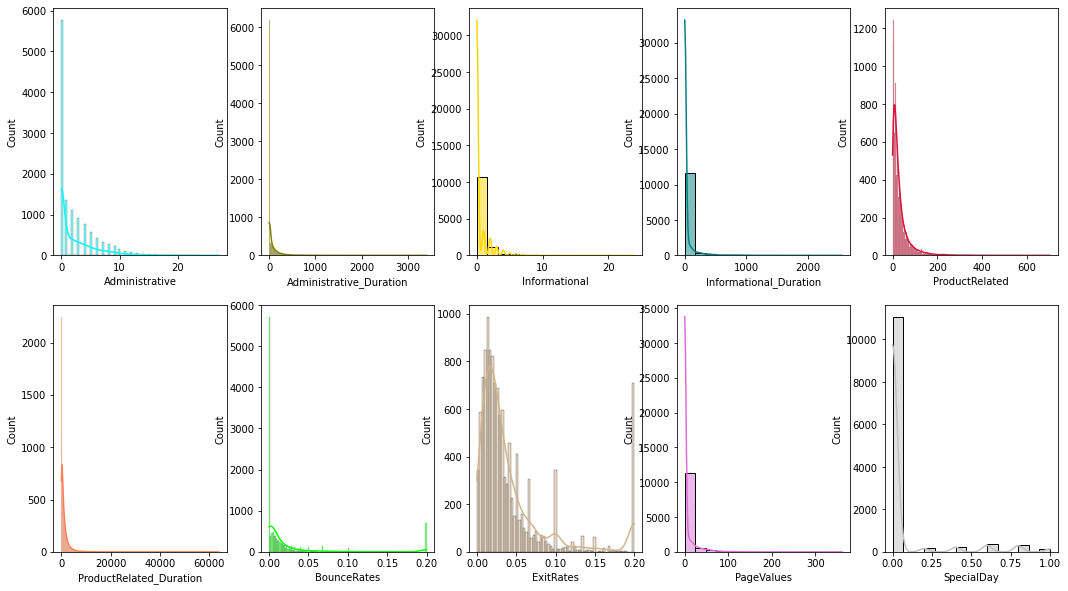

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(18, 10))

sns.histplot(data1, x="Administrative", kde=True, color="cyan", ax=axs[0, 0])
sns.histplot(data1, x="Administrative_Duration", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data1, x="Informational", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data1, x="Informational_Duration", kde=True, color="teal", ax=axs[0, 3])
sns.histplot(data1, x="ProductRelated", kde=True, color="crimson", ax=axs[0,4])
sns.histplot(data1, x="ProductRelated_Duration", kde=True, color="coral", ax=axs[1,0])
sns.histplot(data1, x="BounceRates", kde=True, color="lime", ax=axs[1,1])
sns.histplot(data1, x="ExitRates", kde=True, color="tan", ax=axs[1,2])
sns.histplot(data1, x="PageValues", kde=True, color="orchid", ax=axs[1,3])
sns.histplot(data1, x="SpecialDay", kde=True, color="silver", ax=axs[1,4])

plt.show()

####Create the feature matrix X and the labels array Y

In [17]:
data_X = data1.copy().drop(['Revenue'], axis = 1)
data_Y = data1['Revenue'].copy()

####Check correlation of features

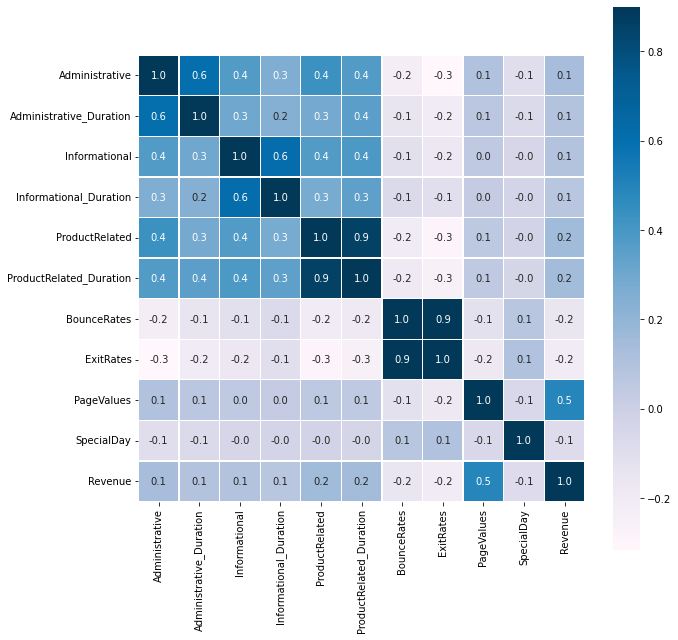

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(data1.corr(), ax=ax, vmax = 0.9, square = True, annot = True, linewidths = 0.3, cmap='PuBu', fmt = '.1f')

#Data Pre-Processing

####Spliting the values into test and train data

In [19]:
train_x, test_x, train_y, test_y = train_test_split(data_X, data_Y, test_size = 0.3, random_state = 42, stratify = data_Y)
train_x.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
7460,4,45.40,0,0.0,14,339.000000,0.000000,0.010526,0.0,0.0,Jul,2,2,1,5,New_Visitor,False
4687,1,40.25,0,0.0,19,501.766667,0.000000,0.010526,0.0,0.0,May,2,2,1,4,Returning_Visitor,False
790,0,0.00,0,0.0,13,244.166667,0.000000,0.030769,0.0,0.0,Mar,2,5,3,3,Returning_Visitor,False
9057,6,62.75,0,0.0,46,1098.524802,0.007083,0.016530,0.0,0.0,Nov,1,1,4,8,Returning_Visitor,False
225,0,0.00,0,0.0,2,19.000000,0.000000,0.100000,0.0,0.0,Mar,2,2,3,11,Returning_Visitor,True


In [20]:
cat_features = train_x.select_dtypes(include = ['object', 'bool']).columns
num_features = train_x.select_dtypes(include = ['int64', 'float64']).columns

####General Pre-processing

In [21]:
pre_proc_pipeline = ColumnTransformer([
                                       ('scale', MinMaxScaler(), num_features),
                                       ('encode', OneHotEncoder(), cat_features)
])

In [22]:
prep_train_x = pre_proc_pipeline.fit_transform(train_x)

In [23]:
prep_test_x = pre_proc_pipeline.transform(test_x)
#prep_test_x = pd.DataFrame.sparse.from_spmatrix(prep_test_x)

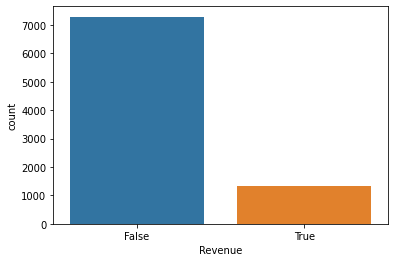

In [24]:
sns.countplot(train_y)

In [25]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_x, oversampled_y = sm.fit_resample(prep_train_x, train_y)
oversampled = pd.concat([pd.DataFrame(oversampled_y), pd.DataFrame(oversampled_x)], axis=1)

In [26]:
processed_train_x = pd.DataFrame(pd.DataFrame.sparse.from_spmatrix(oversampled_x))
processed_train_y = pd.DataFrame(oversampled_y)

####Encoding

In [27]:
enc_train_x = pd.get_dummies(train_x, columns=cat_features, drop_first = True)

In [28]:
enc_test_x = pd.get_dummies(test_x, columns=cat_features, drop_first = True)
enc_test_x = enc_test_x.reindex(columns = enc_train_x.columns, fill_value = 0)

####Feature Selection

In [29]:
cat_features_1 = enc_train_x.select_dtypes(exclude = ['int64', 'float64']).columns

In [30]:
chi_scores = chi2(enc_train_x[cat_features_1], train_y)
p_values = pd.DataFrame(chi_scores[1],index = enc_train_x[cat_features_1].columns, columns = ['score'])

In [31]:
les_sig_fea = p_values[p_values.score > 0.05].sort_values(by = 'score').index.tolist()

In [32]:
reform_train_x = enc_train_x.copy()
reform_train_x.drop(les_sig_fea, axis = 1, inplace = True)

In [33]:
reform_test_x = enc_test_x.copy()
reform_test_x.drop(les_sig_fea, axis = 1, inplace = True)

####Scalling

In [34]:
scaler = MinMaxScaler()
reform_train_x[num_features] = scaler.fit_transform(reform_train_x[num_features])

In [35]:
reform_test_x[num_features] = scaler.transform(reform_test_x[num_features])

####Check imbalanced data

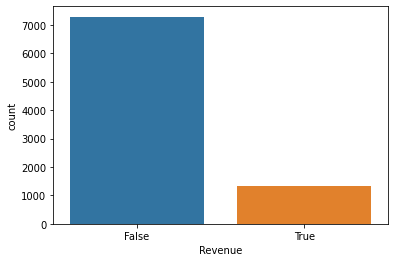

In [36]:
sns.countplot(train_y)

In [37]:
sm = SMOTE(sampling_strategy = 'minority', random_state = 42)
oversampled_x, oversampled_y = sm.fit_resample(reform_train_x, train_y)

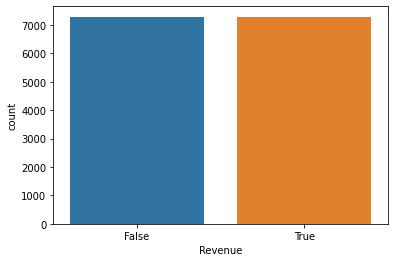

In [38]:
sns.countplot(oversampled_y)

####Multicollinearity

In [39]:
def calc_VIF(df):
  vif_df= pd.DataFrame()
  vif_df['variables']=df.columns
  vif_df["VIF"]=[variance_inflation_factor(df.values,i) for i in range(df.shape[1])]

  return(vif_df)

In [40]:
vif_df = calc_VIF(oversampled_x[num_features])
rem_num_var_list = []
while 1:
  if vif_df['VIF'].max() < 6:
    break;
  else:
    rem_var = vif_df['variables'].max()
    var_list = vif_df['variables'].tolist()
    var_list.remove(rem_var)
    rem_num_var_list.append(rem_var)
    vif_df = calc_VIF(oversampled_x[var_list])

vif_df

,variables,VIF
0,Administrative,3.004435
1,Administrative_Duration,2.112829
2,Informational,2.412814
3,Informational_Duration,1.926189
4,ProductRelated,2.019820
5,BounceRates,4.996104
6,ExitRates,5.331751
7,PageValues,1.157252


In [41]:
oversampled_x.drop(rem_num_var_list, axis = 1, inplace = True)
reform_test_x.drop(rem_num_var_list, axis = 1, inplace = True)

#Model Implementation

##Logistic Regression

####Set Hyperparameter and Train the model

In [46]:
model = LogisticRegression()
model.fit(oversampled_x, oversampled_y)
y_pred = model.predict(reform_test_x)
print('Accuracy of logistic regression classifier on test set: {}'.format(model.score(reform_test_x, test_y)))

Accuracy of logistic regression classifier on test set: 0.8272506082725061


In [47]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [5000, 10000, 15000]

In [48]:
op_log_reg = LogisticRegression()
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=op_log_reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(oversampled_x, oversampled_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.852342 using {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [49]:
op_log_reg = LogisticRegression(C = 10000, penalty = 'l2', solver = 'lbfgs')
op_log_reg.fit(oversampled_x, oversampled_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [131]:
#print('Accuracy of logistic regression classifier on test set: {}'.format(op_log_reg.score(reform_test_x, test_y)))

Accuracy of logistic regression classifier on test set: 0.8669910786699108


In [50]:
lg_pred_t_y = op_log_reg.predict(oversampled_x)
lg_pred_y = op_log_reg.predict(reform_test_x)

In [133]:
#print('Accuracy on train set: {}'.format(accuracy_score(lg_pred_t_y, oversampled_y)))
#print('Accuracy on test set: {}'.format(accuracy_score(lg_pred_y, test_y)))

Accuracy on train set: 0.8533241946538725
Accuracy on test set: 0.8669910786699108


In [135]:
#evaluation of actual data
#conf_mat = confusion_matrix(test_y, lg_pred_y)
#print(conf_mat)
#rep = classification_report(test_y, lg_pred_y)

[[2785  342]
 [ 150  422]]


##Super Vector Machine

####Set hyperparameter and train the model

In [43]:
gamma = ['scale']
C = [100, 200]
kernel = ['poly', 'rbf', 'sigmoid']

op_svm = SVC()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict(kernel = kernel, C = C, gamma = gamma)

grid_search = GridSearchCV(estimator=op_svm, param_grid=grid, n_jobs=-1, cv = cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(oversampled_x, oversampled_y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.898926 using {'C': 200, 'gamma': 'scale', 'kernel': 'rbf'}


In [44]:
op_svm = SVC(C = 200, gamma = 'scale', kernel = 'rbf')
op_svm.fit(oversampled_x, oversampled_y)

SVC(C=200)

In [45]:
svm_pred_t_y = op_svm.predict(oversampled_x)
svm_pred_y = op_svm.predict(reform_test_x)

In [61]:
#print('Accuracy of SVM on test set: {}'.format(op_svm.score(reform_test_x, test_y)))

Accuracy of SVM on test set: 0.8496891051635577


In [57]:
#evaluation
#conf_mat = confusion_matrix(test_y, svm_pred_y)
#print(conf_mat)
#print(classification_report(test_y, svm_pred_y))

[[2746  381]
 [ 178  394]]


##LightGBM

In [51]:
lgbm = lgb.LGBMClassifier(silent=False)
param_dist = {"learning_rate" : [0.06, 0.07, 0.08],
              "max_depth": [40, 50, 60],
              "n_estimators": [200, 300],
              "num_leaves": [50, 100, 150]
             }

grid_search = GridSearchCV(estimator = lgbm, param_grid = param_dist, n_jobs = -1, cv = 3, verbose = 5, scoring = 'roc_auc')
grid_result = grid_search.fit(oversampled_x, oversampled_y)
print('Best:{} using: {}'.format(grid_result.best_score_, grid_result.best_estimator_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best:0.9839572972615948 using: LGBMClassifier(learning_rate=0.07, max_depth=50, n_estimators=300,
               num_leaves=100, silent=False)


In [52]:
op_lgbm = lgb.LGBMClassifier(num_leaves=100, learning_rate=0.07, max_depth=50, n_estimators=300)
op_lgbm.fit(oversampled_x, oversampled_y)

LGBMClassifier(learning_rate=0.07, max_depth=50, n_estimators=300,
               num_leaves=100)

In [53]:
lgbm_pred_t_y = op_lgbm.predict(oversampled_x)
lgbm_pred_y = op_lgbm.predict(reform_test_x)

In [144]:
#print('Accuracy of test data: {}'.format(accuracy_score(lgbm_pred_y, test_y)))
#print('Accuracy of train data: {}'.format(accuracy_score(lgbm_pred_t_y, oversampled_y)))

Accuracy of test data: 0.8861854555285212
Accuracy of train data: 0.9998629198080877


In [145]:
#evaluation
#conf_mat = confusion_matrix(test_y, lgbm_pred_y)
#print(conf_mat)
#print(classification_report(test_y, lgbm_pred_y))

[[2905  222]
 [ 199  373]]
              precision    recall  f1-score   support

       False       0.94      0.93      0.93      3127
        True       0.63      0.65      0.64       572

    accuracy                           0.89      3699
   macro avg       0.78      0.79      0.79      3699
weighted avg       0.89      0.89      0.89      3699



#Performance Evaluation

####Confision Matrix

In [55]:
print('Logistic Regression: \n{}'.format(confusion_matrix(test_y, lg_pred_y)))
print('SVM model: \n{}'.format(confusion_matrix(test_y, svm_pred_y)))
print('LightGBM: \n{}'.format(confusion_matrix(test_y, lgbm_pred_y)))

Logistic Regression: 
[[2785  342]
 [ 150  422]]
SVM model: 
[[2746  381]
 [ 178  394]]
LightGBM: 
[[2905  222]
 [ 199  373]]


####Accuracy

In [58]:
print('Logistic Regression: train-data = {}; test-data = {}'.
      format(accuracy_score(lg_pred_t_y, oversampled_y), accuracy_score(lg_pred_y, test_y)))
print('SVM: train-data = {}; test-data = {}'.
      format(accuracy_score(svm_pred_t_y, oversampled_y), accuracy_score(svm_pred_y, test_y)))
print('LightGBM: train-data = {}; test-data = {}'.
      format(accuracy_score(lgbm_pred_t_y, oversampled_y), accuracy_score(lgbm_pred_y, test_y)))

Logistic Regression: train-data = 0.8533241946538725; test-data = 0.8669910786699108
SVM: train-data = 0.9269362577107608; test-data = 0.8488780751554474
LightGBM: train-data = 0.9998629198080877; test-data = 0.8861854555285212


####Precision

In [61]:
print('Logistic Regression: {}'.format(precision_score(test_y, lg_pred_y)))
print('SVM: {}'.format(precision_score(test_y, svm_pred_y)))
print('LightGBM: {}'.format(precision_score(test_y, lgbm_pred_y)))

Logistic Regression: 0.5523560209424084
SVM: 0.5083870967741936
LightGBM: 0.626890756302521


####Recall

In [62]:
print('Logistic Regression: {}'.format(recall_score(test_y, lg_pred_y)))
print('SVM: {}'.format(recall_score(test_y, svm_pred_y)))
print('LightGBM: {}'.format(recall_score(test_y, lgbm_pred_y)))

Logistic Regression: 0.7377622377622378
SVM: 0.6888111888111889
LightGBM: 0.6520979020979021


####F1-score

In [63]:
print('Logistic Regression: {}'.format(f1_score(test_y, lg_pred_y)))
print('SVM: {}'.format(f1_score(test_y, svm_pred_y)))
print('LightGBM: {}'.format(f1_score(test_y, lgbm_pred_y)))

Logistic Regression: 0.6317365269461078
SVM: 0.585003711952487
LightGBM: 0.6392459297343616


#Result Analysis